In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# Set device id to 1 and 0 


# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


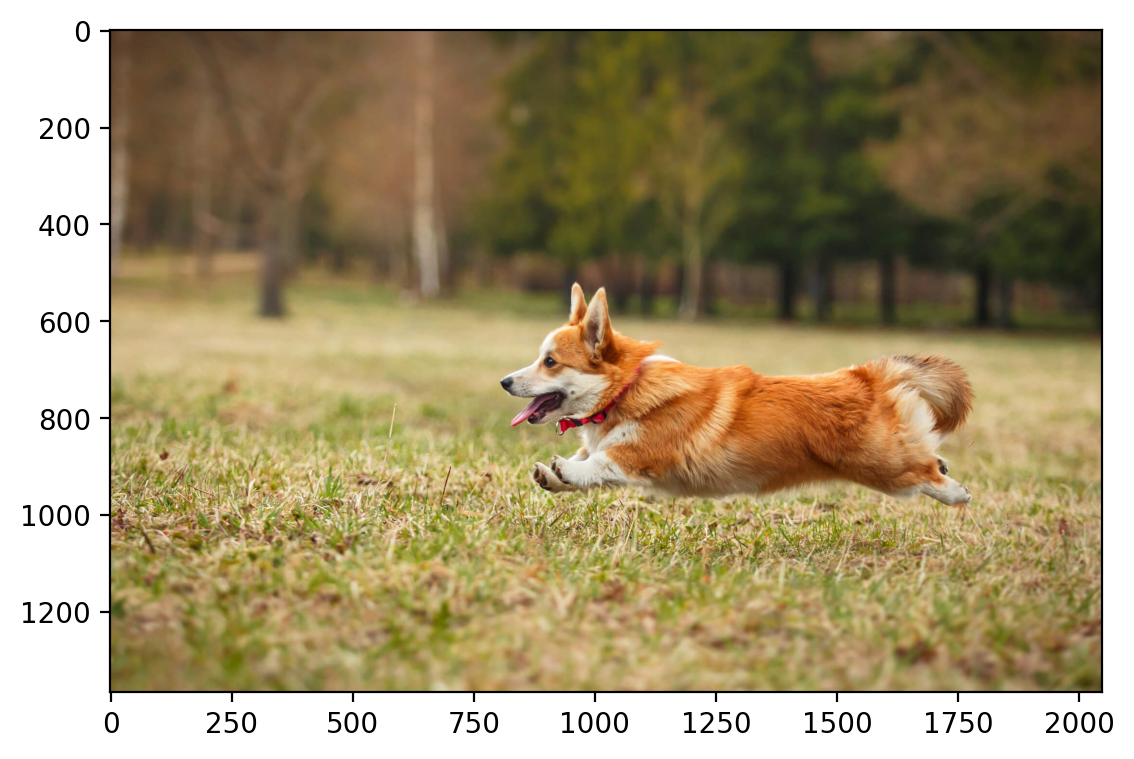

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
img,img.min(),img.max()

(tensor([[[ 79,  80,  80,  ...,  75,  75,  76],
          [ 79,  80,  80,  ...,  75,  75,  76],
          [ 79,  80,  80,  ...,  75,  75,  76],
          ...,
          [121, 121, 122,  ...,  97,  96,  96],
          [121, 121, 122,  ...,  97,  97,  96],
          [121, 121, 122,  ...,  98,  97,  97]],
 
         [[ 52,  53,  53,  ...,  55,  55,  54],
          [ 52,  53,  53,  ...,  55,  55,  54],
          [ 52,  53,  53,  ...,  55,  55,  54],
          ...,
          [103, 103, 104,  ...,  82,  81,  81],
          [103, 103, 104,  ...,  82,  82,  81],
          [103, 103, 104,  ...,  83,  82,  82]],
 
         [[ 35,  36,  36,  ...,  30,  30,  30],
          [ 35,  36,  36,  ...,  30,  30,  30],
          [ 35,  36,  36,  ...,  30,  30,  30],
          ...,
          [ 37,  37,  38,  ...,  43,  42,  42],
          [ 37,  37,  38,  ...,  43,  43,  42],
          [ 37,  37,  38,  ...,  44,  43,  43]]], dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 tensor(255, dtype=torch.uint8))

In [6]:
# We normalize the image to be between 0 and 1
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [7]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [8]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

The main reason behind cropping the image is to restrict the size of the image due to constrained computational power. The size of the input image is a key factor in determining the requirements of the GPU memory. 

In [9]:
# Cropping the image at fixed location around the face of the dog
orig_img = torchvision.transforms.functional.crop(img_scaled.cpu(), 500, 800, 360, 360)
orig_img.shape

torch.Size([3, 360, 360])

In [10]:
# Resize the image to 200x200
crop = torchvision.transforms.functional.resize(orig_img, (180, 180))

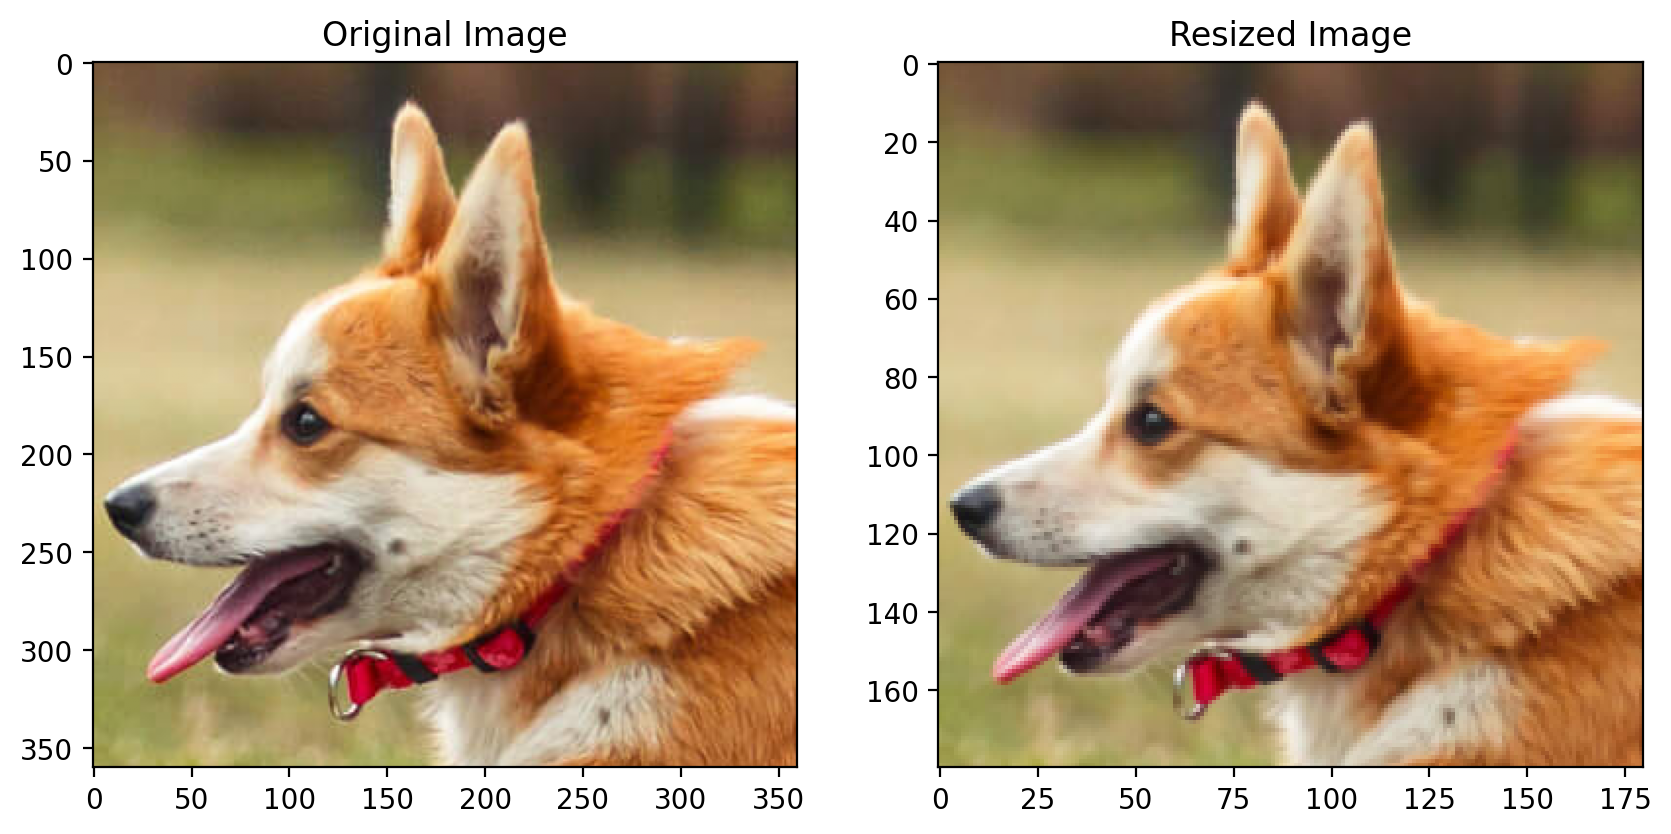

In [11]:
# Plot both the original and the cropped image
figsize = (10, 5)
fig, ax = plt.subplots(1, 2, figsize=figsize)

ax[0].imshow(rearrange(orig_img, 'c h w -> h w c').cpu().numpy())
ax[1].imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

# Set the titles 
ax[0].set_title('Original Image')
ax[1].set_title('Resized Image')

plt.show()

In [12]:
crop = crop.to(device)

In [13]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 180 180


In [14]:
def create_coordinate_map(img, scale=1):
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [15]:
# create RFF features
from sklearn.kernel_approximation import RBFSampler
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2),random_state=42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [16]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)
    

def train(net, lr, X, Y, epochs, verbose=True):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [17]:
def plot_reconstructed_and_original_image(original_img, crop,net, X, scale = 1, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = crop.shape
    height *= scale
    width *= scale
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        
    fig = plt.figure(figsize=(9, 6))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1,1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(crop.cpu().permute(1, 2, 0))
    ax1.set_title("Resized Image")
    
    ax2.imshow(original_img.cpu().permute(1, 2, 0))
    ax2.set_title("Original Image")
    
    # for a in [ax0, ax1]:
    #     a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    
    return outputs

In [18]:
num_features = 30000
sigma = 0.008

In [ ]:
# If pickle file exists, load the model
import pickle 

if not os.path.exists('net.pkl'):
    # Coordinates and image
    dog_X, dog_Y = create_coordinate_map(crop,scale=1)
    print(dog_X.shape, dog_Y.shape)

    # MinMaxScaler from -1 to 1
    scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

    # Scale the X coordinates
    dog_X_scaled = scaler_X.transform(dog_X.cpu())

    # Move the scaled X coordinates to the GPU
    dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

    # Set to dtype float32
    dog_X_scaled = dog_X_scaled.float()
    
    
    X_rff = create_rff_features(dog_X_scaled, num_features, sigma)

    net = LinearModel(X_rff.shape[1], 3)
    net.to(device)

    train(net, 0.005, X_rff, dog_Y, 2500)
    
    with open("net.pkl", "wb") as f:
        pickle.dump(net, f)
    
else:
    with open("net.pkl", "rb") as f:
        net = pickle.load(f)

In [20]:
def resolve_image(net, orig_img, crop, scale=1):
    # Coordinates and image
    dog_X, dog_Y = create_coordinate_map(crop,scale)
    print(dog_X.shape, dog_Y.shape)

    # MinMaxScaler from -1 to 1
    scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

    # Scale the X coordinates
    dog_X_scaled = scaler_X.transform(dog_X.cpu())

    # Move the scaled X coordinates to the GPU
    dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

    # Set to dtype float32
    dog_X_scaled = dog_X_scaled.float()
    X_rff = create_rff_features(dog_X_scaled, num_features, sigma)
    outputs = plot_reconstructed_and_original_image(orig_img, crop, net, X_rff, scale , title="Reconstructed Image")
    return outputs
    
    

torch.Size([32400, 2]) torch.Size([32400, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


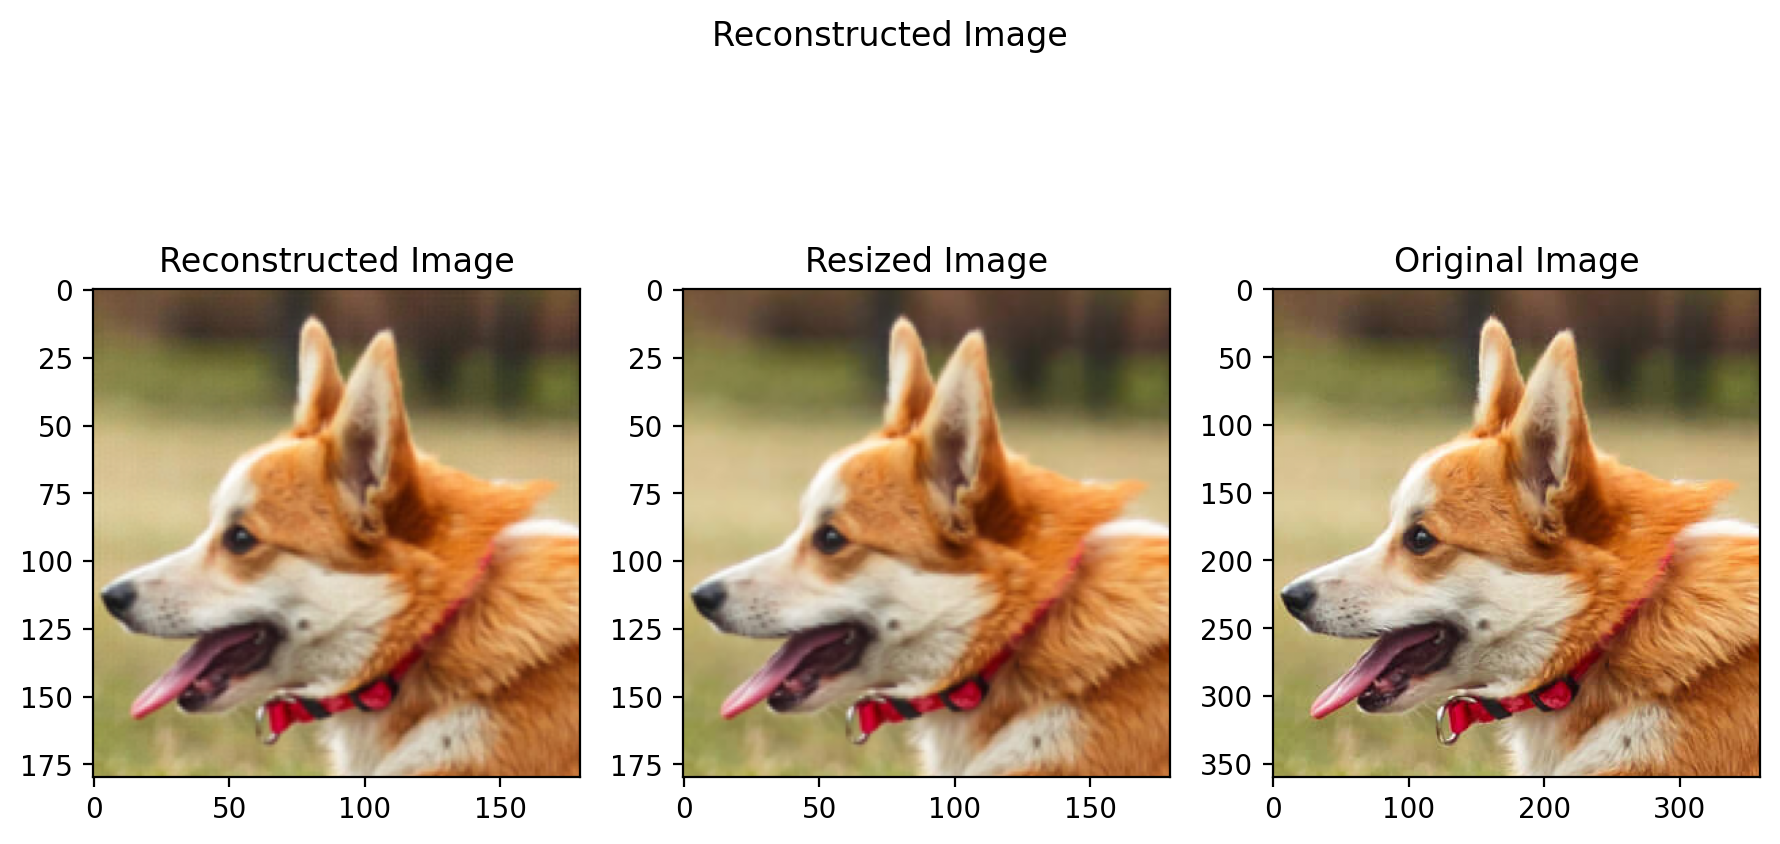

In [21]:
opt = resolve_image(net, orig_img, crop, scale=1)

torch.Size([129600, 2]) torch.Size([32400, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


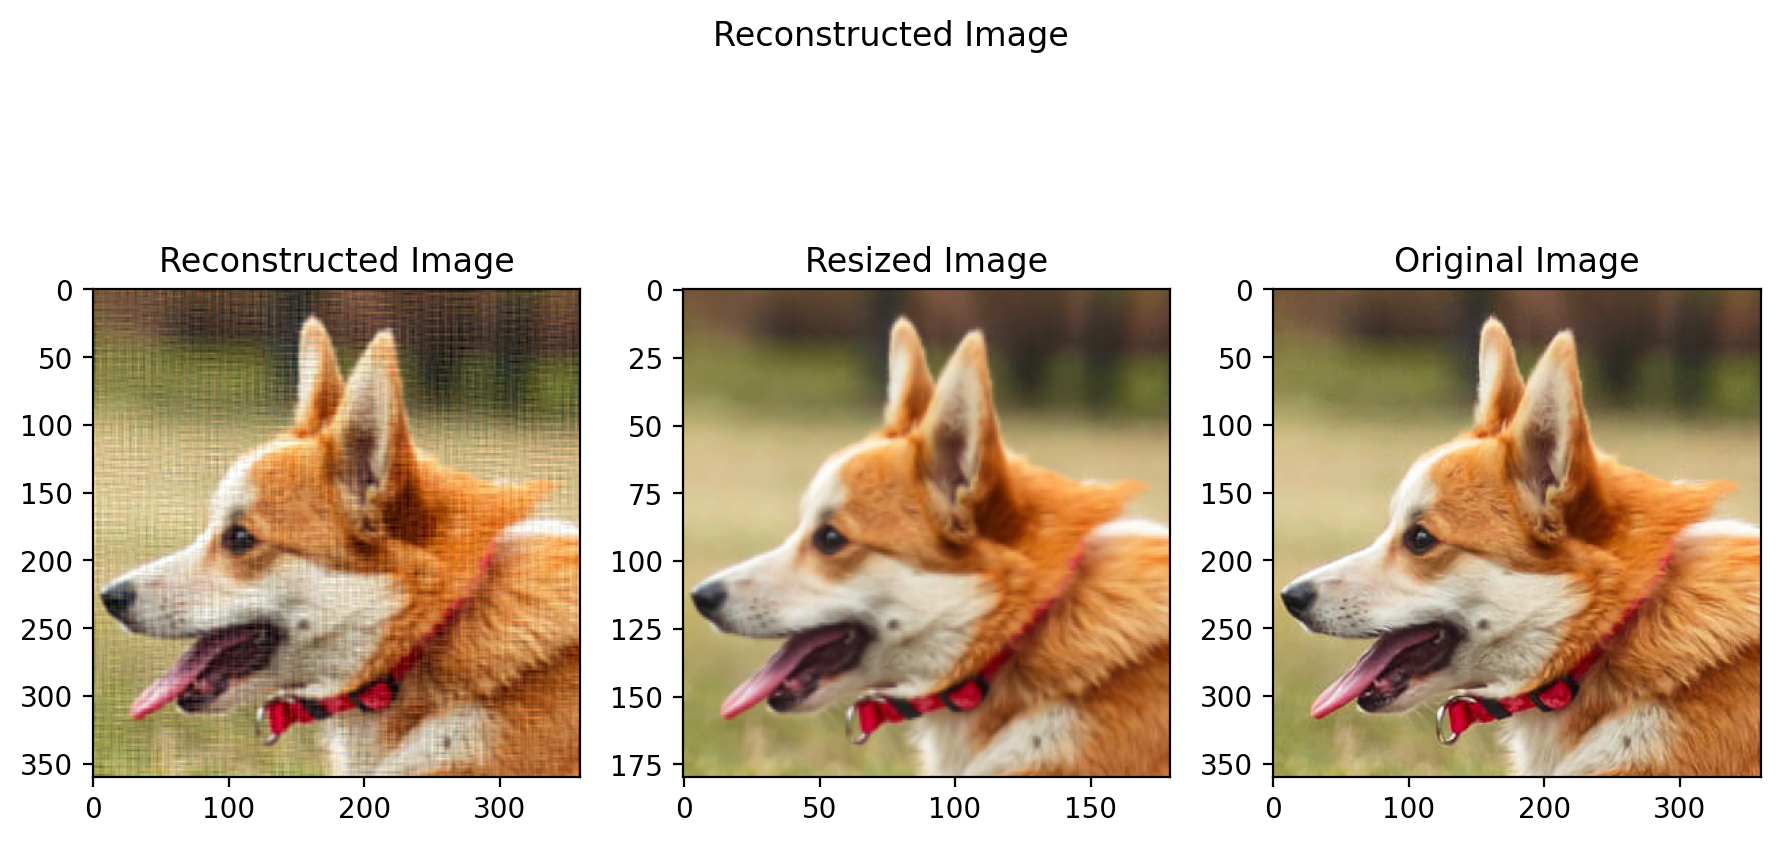

In [22]:
# Please rerun the code to avoid the error
opt = resolve_image(net, orig_img, crop, scale=2)

In [23]:
def metric(orig_img,opt):
    mse = F.mse_loss(orig_img, opt)
    rmse = torch.sqrt(mse)
    psnr = 20 * torch.log10(1/rmse)
    return mse, rmse, psnr


opt = rearrange(opt, 'h w c -> c h w')
orig_img = rearrange(orig_img, 'c h w -> c h w')

print(opt.shape)
print(orig_img.shape)

orig_img = orig_img.to(device)
opt = opt.to(device)

mse, rmse, psnr = metric(orig_img, opt)

torch.Size([3, 360, 360])
torch.Size([3, 360, 360])


In [24]:
print(f"MSE: {mse.item():.4f}")
print(f"RMSE: {rmse.item():.4f}")
print(f"PSNR: {psnr.item():.4f}")

MSE: 0.0022
RMSE: 0.0468
PSNR: 26.5989
